# Coffea Processors
This is a rendered copy of [processor.ipynb](https://github.com/CoffeaTeam/coffea/blob/master/binder/processor.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fprocessor.ipynb)

Coffea relies mainly on [uproot](https://github.com/scikit-hep/uproot) to provide access to ROOT files for analysis.
As a usual analysis will involve processing tens to thousands of files, totalling gigabytes to terabytes of data, there is a certain amount of work to be done to build a parallelized framework to process the data in a reasonable amount of time. Of course, one can work directly within uproot to achieve this, as we'll show in the beginning, but coffea provides the `coffea.processor` module, which allows users to worry just about the actual analysis code and not about how to implement efficient parallelization, assuming that the parallization is a trivial map-reduce operation (e.g. filling histograms and adding them together). The module provides the following key features:

 * A `ProcessorABC` abstract base class that can be derived from to implement the analysis code;
 * An interface to the arrays being read from the TTree, either [DataFrame](https://coffeateam.github.io/coffea/api/coffea.processor.LazyDataFrame.html#coffea.processor.LazyDataFrame) or [NanoEvents](https://coffeateam.github.io/coffea/notebooks/nanoevents.html), to be used as inputs;
 * A set of [accumulator types](https://coffeateam.github.io/coffea/api/coffea.processor.AccumulatorABC.html#coffea.processor.AccumulatorABC), such as `dict_accumulator` or `Hist` to be used as output (new with v0.7.2: any object that duck types to addable or a dictionary); and
 * A set of parallel executors to access multicore processing or distributed computing systems such as [Dask](https://distributed.dask.org/en/latest/), [Parsl](http://parsl-project.org/), [Spark](https://spark.apache.org/), and others.

Let's start by writing a simple processor class that reads some CMS open data and plots a dimuon mass spectrum.
We'll start by copying the [ProcessorABC](https://coffeateam.github.io/coffea/api/coffea.processor.ProcessorABC.html#coffea.processor.ProcessorABC) skeleton and filling in some details:

 * Adding a new histogram for $m_{\mu \mu}$
 * Building a [Candidate](https://coffeateam.github.io/coffea/api/coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate.html#coffea.nanoevents.methods.candidate.PtEtaPhiMCandidate) record for muons
 * Calculating the dimuon invariant mass

In [1]:
import awkward as ak
import hist
from coffea import processor
from coffea.nanoevents.methods import candidate

class MyProcessor(processor.ProcessorABC):
    def process(self, events):
        dataset = events.metadata['dataset']
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        cut = (ak.num(muons) == 2) & (ak.sum(muons.charge, axis=1) == 0)
        # add first and second muon in every event together
        dimuon = muons[cut][:, 0] + muons[cut][:, 1]
        
        masshist = (
            hist.Hist.new
            .Log(1000, 0.2, 200., label="$m_{\mu\mu}$ [GeV]")
            .Double()
        )
        masshist.fill(dimuon.mass)

        return {
            dataset: {
                "entries": len(events),
                "mass": masshist,
            }
        }

    def postprocess(self, accumulator):
        return accumulator

If we were to just use bare uproot to execute this processor, we could do that with the following example, which:

 * Opens a CMS open data file
 * Creates a NanoEvents object using `BaseSchema` (roughly equivalent to the output of `uproot.lazy`)
 * Creates a `MyProcessor` instance
 * Runs the `process()` function, which returns our accumulators


In [11]:
import uproot
from coffea.nanoevents import NanoEventsFactory, BaseSchema

filename = "root://xcache//store/user/ncsmith/opendata_mirror/Run2012B_DoubleMuParked.root"
file = uproot.open(filename)
events = NanoEventsFactory.from_root(
    file,
    entry_stop=10000,
    metadata={"dataset": "DoubleMuon"},
    schemaclass=BaseSchema,
).events()
p = MyProcessor()
out = p.process(events)
out

{'DoubleMuon': {'entries': 10000,
  'mass': Hist(Regular(1000, 0.2, 200, transform=log, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 3722.0 (3729.0 with flow)}}

In [3]:
out["DoubleMuon"]["mass"]

Hist(Regular(1000, 0.2, 200, transform=log, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 3722.0 (3729.0 with flow)

One could expand on this code to run over several chunks of the file, setting `entry_start` and `entry_stop` as appropriate. Then, several datasets could be processed by iterating over several files. However, [run_uproot_job](https://coffeateam.github.io/coffea/api/coffea.processor.run_uproot_job.html#coffea.processor.run_uproot_job) can help with this. One lists the datasets and corresponding files, the processor they want to run, and which executor they want to use. Available executors are listed [here](https://coffeateam.github.io/coffea/modules/coffea.processor.html#functions). Since these files are very large, we limit to just reading the first few chunks of events from each dataset with `maxchunks`.

In [16]:
fileset = {
    'DoubleMuon': [
        'root://xcache//store/user/ncsmith/opendata_mirror/Run2012B_DoubleMuParked.root',
        'root://xcache//store/user/ncsmith/opendata_mirror/Run2012C_DoubleMuParked.root',
    ],
    'ZZ to 4mu': [
        'root://xcache//store/user/ncsmith/opendata_mirror/ZZTo4mu.root'
    ]
}

out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": BaseSchema,
    },
    maxchunks=30,
)
out

Processing:   0%|          | 0/45 [00:00<?, ?chunk/s]

{'ZZ to 4mu': {'entries': 1499064,
  'mass': Hist(Regular(1000, 0.2, 200, transform=log, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 198027.0 (198423.0 with flow)},
 'DoubleMuon': {'entries': 3001680,
  'mass': Hist(Regular(1000, 0.2, 200, transform=log, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 1227146.0 (1228419.0 with flow)}}

Now, if we want to use more than a single core on our machine, we simply change [iterative_executor](https://coffeateam.github.io/coffea/api/coffea.processor.iterative_executor.html) for [futures_executor](https://coffeateam.github.io/coffea/api/coffea.processor.futures_executor.html), which uses the python [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html) standard library. Optional arguments to these executors can be provided via `executor_args` parameter of `run_uproot_job`, such as the number of cores to use (4):

In [17]:
out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=MyProcessor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 4},
    maxchunks=30,
)
out

Processing:   0%|          | 0/45 [00:00<?, ?chunk/s]

{'ZZ to 4mu': {'entries': 1499064,
  'mass': Hist(Regular(1000, 0.2, 200, transform=log, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 198027.0 (198423.0 with flow)},
 'DoubleMuon': {'entries': 3001680,
  'mass': Hist(Regular(1000, 0.2, 200, transform=log, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 1227146.0 (1228419.0 with flow)}}

Hopefully this ran faster than the previous cell, but that may depend on how many cores are available on the machine you are running this notebook.

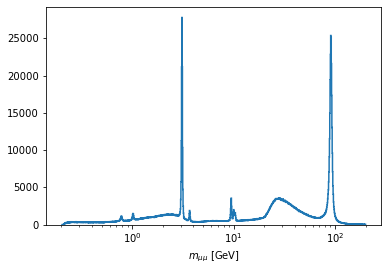

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
out["DoubleMuon"]["mass"].plot1d(ax=ax)
ax.set_xscale("log")

## Getting fancy
Let's flesh out this analysis into a 4-muon analysis, searching for diboson events:

In [21]:
from functools import partial
import numba


@numba.njit
def find_4lep(events_leptons, builder):
    """Search for valid 4-lepton combinations from an array of events * leptons {charge, ...}
    
    A valid candidate has two pairs of leptons that each have balanced charge
    Outputs an array of events * candidates {indices 0..3} corresponding to all valid
    permutations of all valid combinations of unique leptons in each event
    (omitting permutations of the pairs)
    """
    for leptons in events_leptons:
        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0 + 1, nlep):
                if leptons[i0].charge + leptons[i1].charge != 0:
                    continue
                for i2 in range(nlep):
                    for i3 in range(i2 + 1, nlep):
                        if len({i0, i1, i2, i3}) < 4:
                            continue
                        if leptons[i2].charge + leptons[i3].charge != 0:
                            continue
                        builder.begin_tuple(4)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.index(3).integer(i3)
                        builder.end_tuple()
        builder.end_list()

    return builder


class FancyDimuonProcessor(processor.ProcessorABC):
    def process(self, events):
        dataset = events.metadata['dataset']
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
                "softId": events.Muon_softId,
                "isolation": events.Muon_pfRelIso03_all,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        
        # make sure they are sorted by transverse momentum
        muons = muons[ak.argsort(muons.pt, axis=1)]
        
        # track our cuts' yields
        cutflow = {}
        cutflow['all events'] = len(muons)
        
        # impose some quality and minimum pt cuts on the muons
        muons = muons[
            muons.softId
            & (muons.pt > 5)
            & (muons.isolation < 0.2)
        ]
        cutflow['at least 4 good muons'] = ak.sum(ak.num(muons) >= 4)
        nmuons = hist.Hist.new.Reg(6, 0, 6, label="N good muons").Double().fill(ak.num(muons))
        
        # reduce first axis: skip events without enough muons
        muons = muons[ak.num(muons) >= 4]
        
        # find all candidates with helper function
        fourmuon = find_4lep(muons, ak.ArrayBuilder()).snapshot()
        if ak.all(ak.num(fourmuon) == 0):
            # skip processing as it is an EmptyArray
            return {}

        fourmuon = [muons[fourmuon[idx]] for idx in "0123"]
        fourmuon = ak.zip({
            "z1": ak.zip({
                "lep1": fourmuon[0],
                "lep2": fourmuon[1],
                "p4": fourmuon[0] + fourmuon[1],
            }),
            "z2": ak.zip({
                "lep1": fourmuon[2],
                "lep2": fourmuon[3],
                "p4": fourmuon[2] + fourmuon[3],
            }),
        })
        
        cutflow['at least one candidate'] = ak.sum(ak.num(fourmuon) > 0)
         
        # require minimum dimuon mass
        fourmuon = fourmuon[(fourmuon.z1.p4.mass > 60.) & (fourmuon.z2.p4.mass > 20.)]
        cutflow['minimum dimuon mass'] = ak.sum(ak.num(fourmuon) > 0)
        
        # choose permutation with z1 mass closest to nominal Z boson mass
        bestz1 = ak.singletons(ak.argmin(abs(fourmuon.z1.p4.mass - 91.1876), axis=1))
        fourmuon = ak.flatten(fourmuon[bestz1])
        
        out = {
            "cutflow": cutflow,
            "nmuons": nmuons,
            "mass": (
                hist.Hist.new
                .Reg(300, 0, 300, label=r"$m_{4\mu}$ [GeV]").Double()
                .fill((fourmuon.z1.p4 + fourmuon.z2.p4).mass)
            ),
            "mass_z1": (
                hist.Hist.new
                .Reg(300, 0, 300, label=r"$m_{\mu\mu}$ [GeV]").Double()
                .fill(fourmuon.z1.p4.mass)
            ),
            "mass_z2": (
                hist.Hist.new
                .Reg(300, 0, 300, label=r"$m_{\mu\mu}$ [GeV]").Double()
                .fill(fourmuon.z2.p4.mass)
            ),
            "pt_z1": (
                hist.Hist.new
                .Reg(300, 0, 300, label=r"Z1 $p_{T}$ [GeV]").Double()
                .fill(fourmuon.z1.p4.pt)
            ),
            "pt_z2": (
                hist.Hist.new
                .Reg(300, 0, 300, label=r"Z2 $p_{T}$ [GeV]").Double()
                .fill(fourmuon.z2.p4.pt)
            ),
            "pt_z1_mu1": (
                hist.Hist.new
                .Reg(300, 0, 300, name="mass", label=r"Z1 leading muon $p_{T}$ [GeV]").Double()
                .fill(fourmuon.z1.lep1.pt)
            ),
            "pt_z1_mu2": (
                hist.Hist.new
                .Reg(300, 0, 300, name="mass", label=r"Z1 subleading muon $p_{T}$ [GeV]").Double()
                .fill(fourmuon.z1.lep2.pt)
            ),
        }
        return {dataset: out}

    def postprocess(self, accumulator):
        return accumulator

In [22]:
import time

tstart = time.time()    

fileset = {
    'DoubleMuon': [
        'root://xcache//store/user/ncsmith/opendata_mirror/Run2012B_DoubleMuParked.root',
        'root://xcache//store/user/ncsmith/opendata_mirror/Run2012C_DoubleMuParked.root',
    ],
    'ZZ to 4mu': [
        'root://xcache//store/user/ncsmith/opendata_mirror/ZZTo4mu.root'
    ]
}

output = processor.run_uproot_job(
    fileset,
    treename='Events',
    processor_instance=FancyDimuonProcessor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 4},
    chunksize=100_000,
    maxchunks=None,
)

elapsed = time.time() - tstart
print(output)

Processing:   0%|          | 0/676 [00:00<?, ?chunk/s]

{'ZZ to 4mu': {'pt_z2': Hist(Regular(300, 0, 300, label='Z2 $p_{T}$ [GeV]'), storage=Double()) # Sum: 81463.0 (81867.0 with flow), 'mass_z2': Hist(Regular(300, 0, 300, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 81393.0 (81867.0 with flow), 'mass': Hist(Regular(300, 0, 300, label='$m_{4\\mu}$ [GeV]'), storage=Double()) # Sum: 65045.0 (81867.0 with flow), 'pt_z1_mu1': Hist(Regular(300, 0, 300, name='mass', label='Z1 leading muon $p_{T}$ [GeV]'), storage=Double()) # Sum: 81866.0 (81867.0 with flow), 'cutflow': {'at least 4 good muons': 143618, 'minimum dimuon mass': 81867, 'all events': 1499064, 'at least one candidate': 143055}, 'nmuons': Hist(Regular(6, 0, 6, label='N good muons'), storage=Double()) # Sum: 1499044.0 (1499064.0 with flow), 'pt_z1': Hist(Regular(300, 0, 300, label='Z1 $p_{T}$ [GeV]'), storage=Double()) # Sum: 81457.0 (81867.0 with flow), 'mass_z1': Hist(Regular(300, 0, 300, label='$m_{\\mu\\mu}$ [GeV]'), storage=Double()) # Sum: 81820.0 (81867.0 with flow), '

In [23]:
nevt = output['ZZ to 4mu']['cutflow']['all events'] + output['DoubleMuon']['cutflow']['all events']
print("Events/s:", nevt / elapsed)

Events/s: 872595.0538934914


What follows is just us looking at the output, you can execute it if you wish

In [24]:
# scale ZZ simulation to expected yield
lumi = 11.6  # 1/fb
zzxs = 7200 * 0.0336**2  # approximate 8 TeV ZZ(4mu)
nzz = output['ZZ to 4mu']['cutflow']['all events']

data = output["DoubleMuon"]
scaledzz = {}
for name, h in output['ZZ to 4mu'].items():
    if isinstance(h, hist.Hist):
        scaledzz[name] = h.copy()
        scaledzz[name] *= lumi * zzxs / nzz

(1, 122327683.74048436)

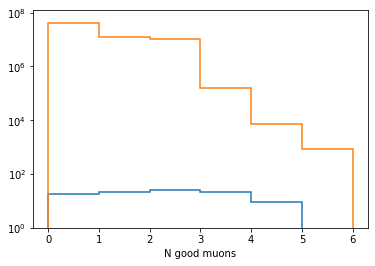

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
scaledzz["nmuons"].plot1d(label="ZZ to 4mu")
data["nmuons"].plot1d()
ax.set_yscale('log')
ax.set_ylim(1, None)

In [26]:
data["cutflow"]

{'all events': 66028814,
 'at least 4 good muons': 8284,
 'at least one candidate': 3849,
 'minimum dimuon mass': 485}

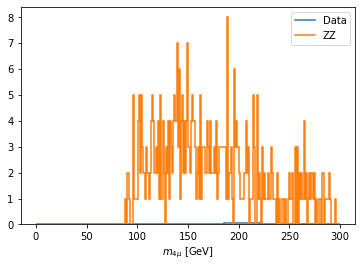

In [29]:
fig, ax = plt.subplots()

plotname = "mass"
scaledzz[plotname].plot1d(ax=ax, label="Data")
data[plotname].plot1d(ax=ax, label="ZZ")
ax.legend()

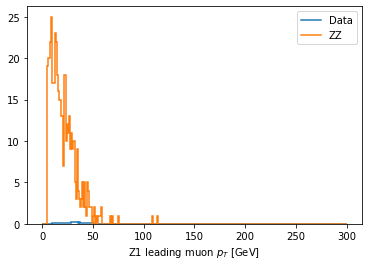

In [30]:
fig, ax = plt.subplots()

plotname = "pt_z1_mu1"
scaledzz[plotname].plot1d(ax=ax, label="Data")
data[plotname].plot1d(ax=ax, label="ZZ")
ax.legend()